In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# TODO: Add total spendings column

In [3]:
# 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
# 2) MILK: annual spending (m.u.) on milk products (Continuous);
# 3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
# 4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
# 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# 6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
# 7) CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
# 8) REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
# Descriptive Statistics:

# (Minimum, Maximum, Mean, Std. Deviation)
# FRESH ( 3, 112151, 12000.30, 12647.329)
# MILK (55, 73498, 5796.27, 7380.377)
# GROCERY (3, 92780, 7951.28, 9503.163)
# FROZEN (25, 60869, 3071.93, 4854.673)
# DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
# DELICATESSEN (3, 47943, 1524.87, 2820.106)

# REGION Frequency
# Lisbon 77
# Oporto 47
# Other Region 316
# Total 440

# CHANNEL Frequency
# Horeca 298
# Retail 142
# Total 440



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [64]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_overview = df.copy()
df


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0    12669   9656     7561     214              2674        1338
1     7057   9810     9568    1762              3293        1776
2     6353   8808     7684    2405              3516        7844
3    13265   1196     4221    6404               507        1788
4    22615   5410     7198    3915              1777        5185
..     ...    ...      ...     ...               ...         ...
435  29703  12051    16027   13135               182        2204
436  39228   1431      764    4510                93        2346
437  14531  15488    30243     437             14841        1867
438  10290   1981     2232    1038               168        2125
439   2787   1698     2510      65               477          52

[440 rows x 6 columns]

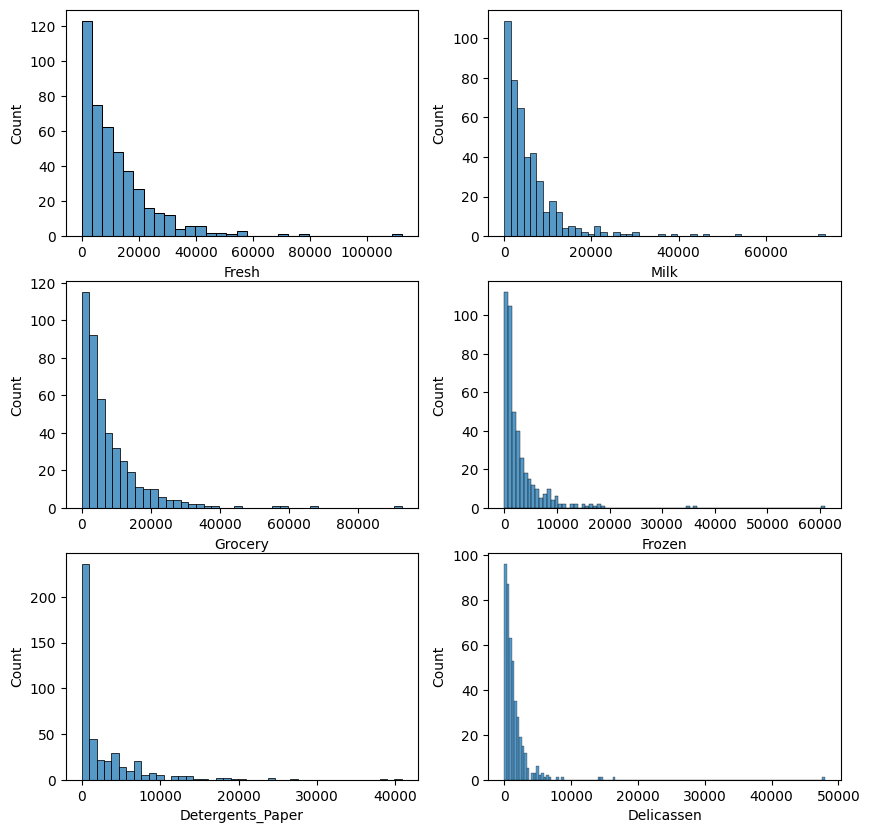

In [65]:
def plot_hist_cols():
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])


plot_hist_cols()


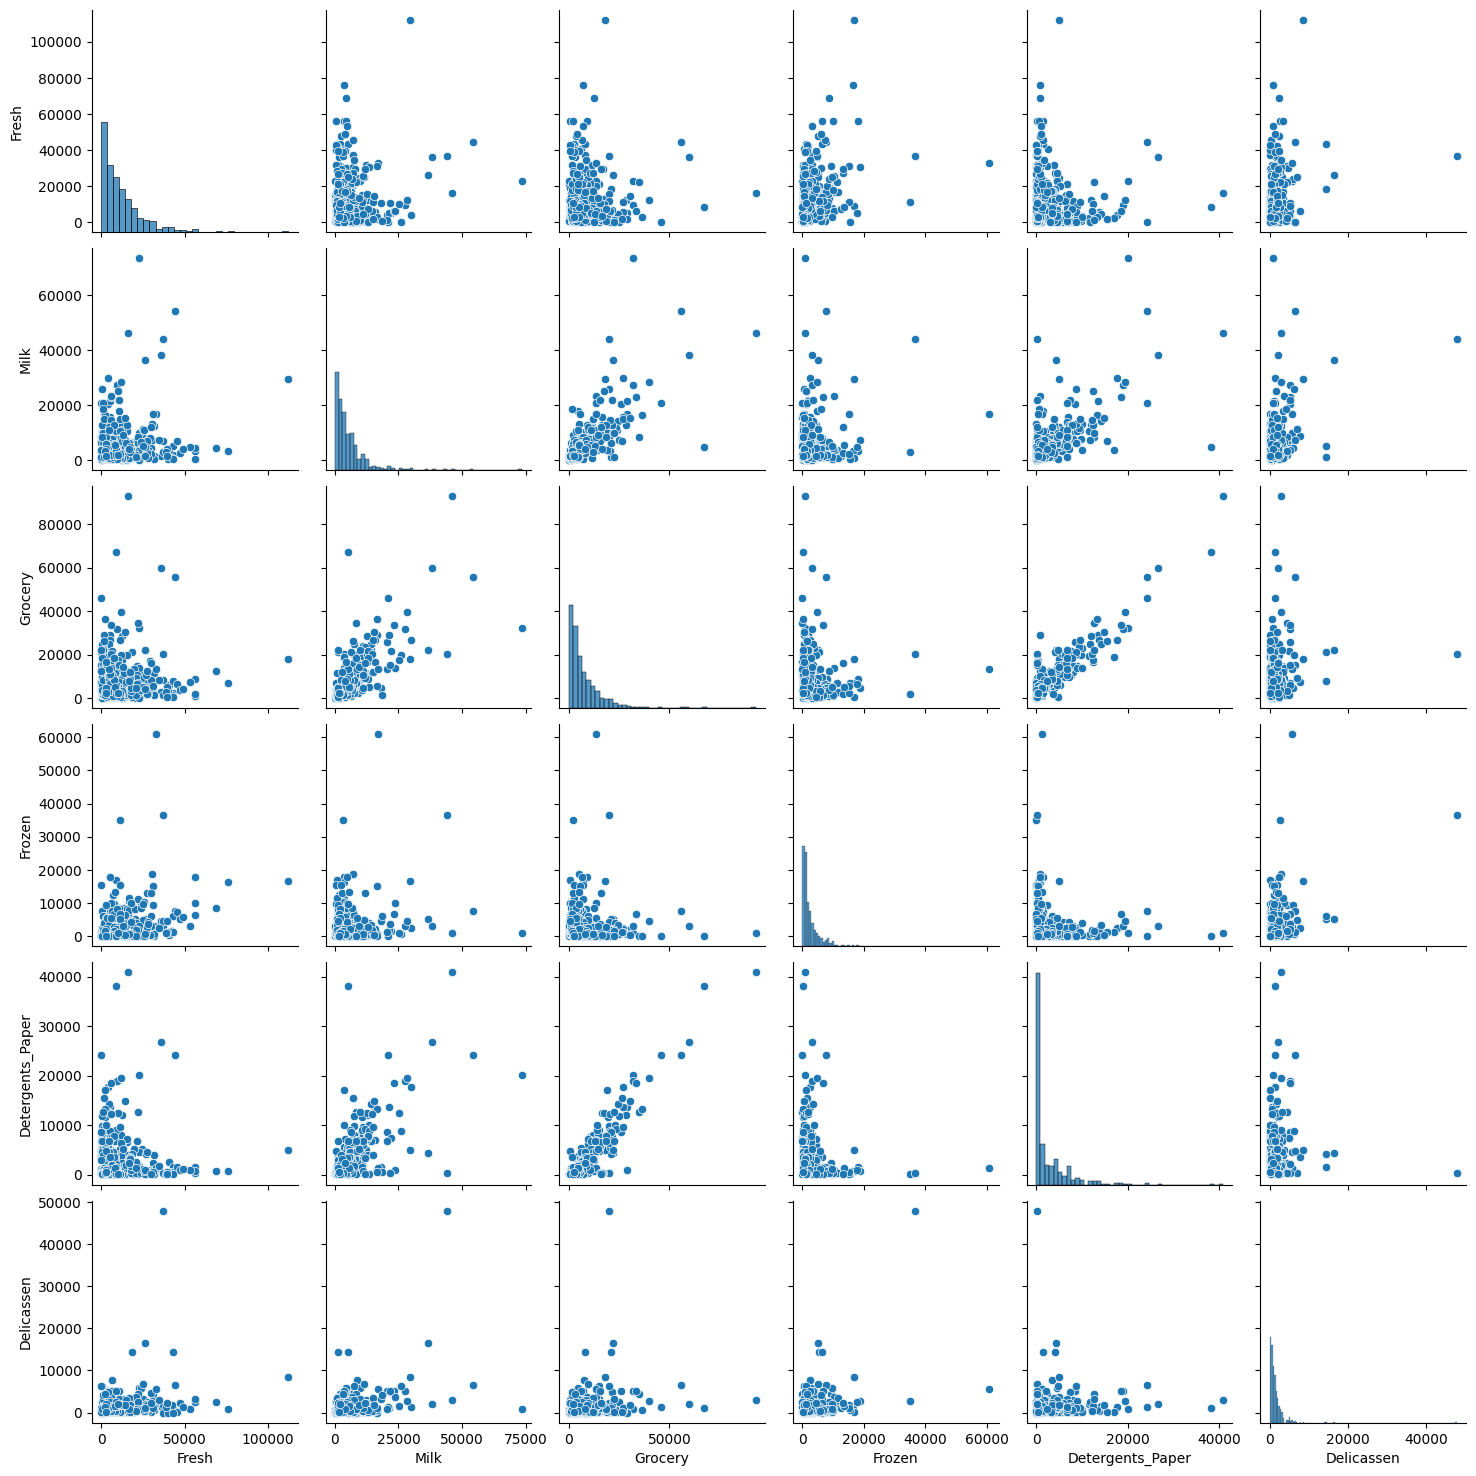

In [66]:
sns.pairplot(df)


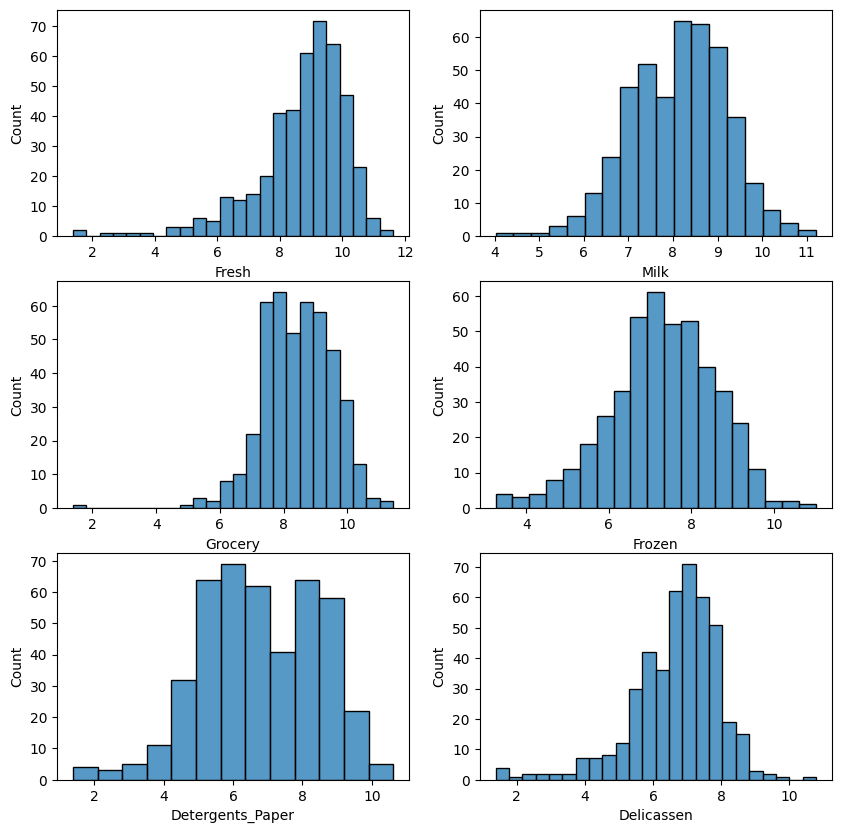

In [67]:
df = np.log(df + 1)
df_overview = df.copy()
plot_hist_cols()


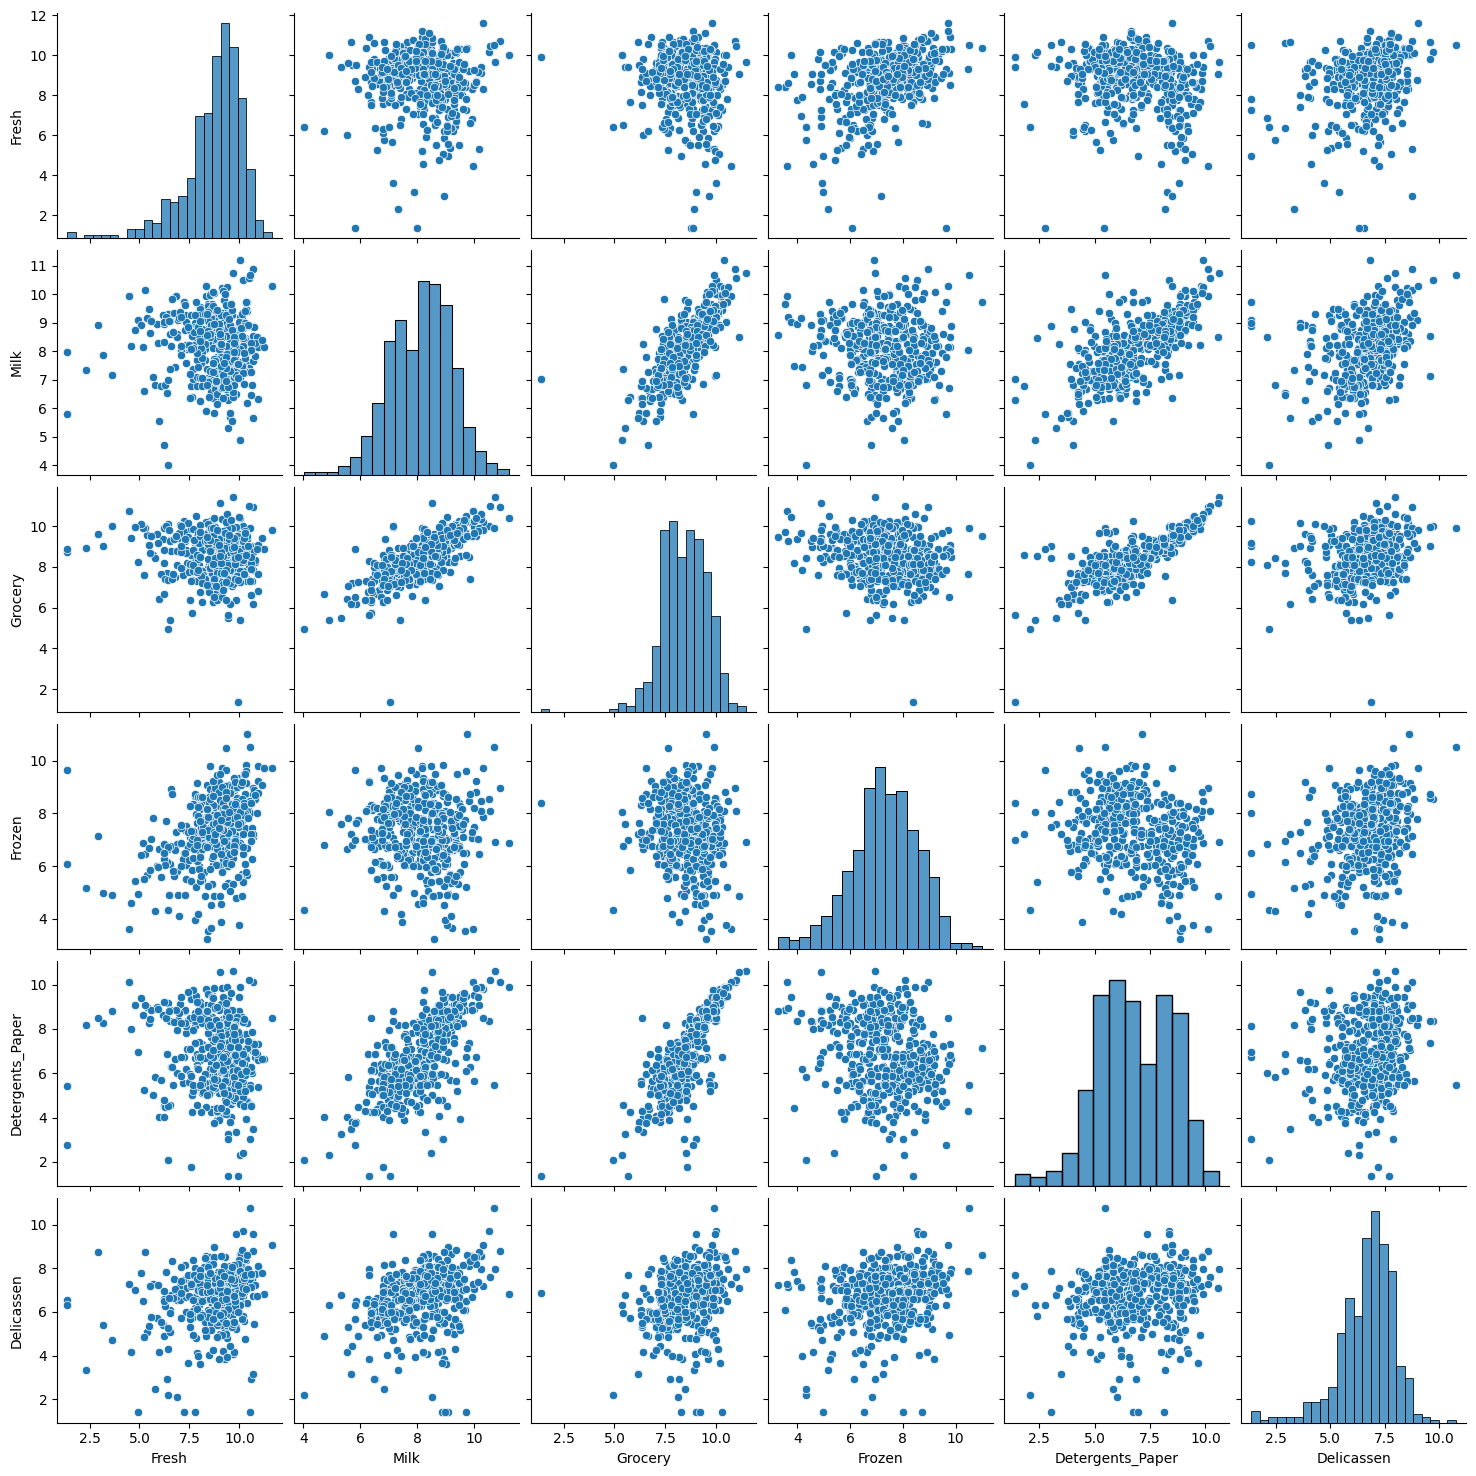

In [68]:
sns.pairplot(df)
# TODO: Add Correlation Plot and a column with total spendings
# Barplot/Pie chart with spendings from total spendings


# 2 Detecting Anomalies
## Hard-Min Score

In [69]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df.to_numpy())
distances, indices = nbrs.kneighbors(df.to_numpy())
df_overview["outlier_score_min"] = distances[:, 1]
df_overview.sort_values(by="outlier_score_min", ascending=False).head(10)

Fresh       Milk    Grocery     Frozen  Detergents_Paper  Delicassen   
338   1.386294   5.811141   8.856803   9.655154          2.772589    6.311735  \
75    9.923241   7.037028   1.386294   8.391176          1.386294    6.883463   
154   6.434547   4.025352   4.927254   4.330733          2.079442    2.197225   
142  10.519673   8.875287   9.018453   8.005033          3.044522    1.386294   
95    1.386294   7.979681   8.740817   6.089045          5.411646    6.565265   
187   7.799343   8.987572   9.192176   8.743532          8.149024    1.386294   
128   4.948760   9.087947   8.249052   4.962845          6.968850    1.386294   
183  10.514557  10.690831   9.912001  10.506026          5.480639   10.777789   
204   7.579168   6.793466   8.561593   7.232733          1.791759    7.192182   
109   7.249215   9.724959  10.274603   6.513230          6.729824    1.386294   

     outlier_score_min  
338           4.945913  
75            4.647444  
154           4.201955  
142           3.774788  
95            3.746081  
187           3.001067  
128           2.973513  
183           2.956699  
204           2.920883  
109           2.721484

In [70]:
print(distances.shape)
# distances: Zeile = sample, Spalte 1 = kürzeste Distanz
# Spalte 0 = alles 0
print(indices.shape)
# indices: erste Spalte 0-440; zweite Spalte: index zur kürzesten Distanz

(440, 2)
(440, 2)


In [71]:
print(distances[0, 1], indices[0])
# quick double check
np.linalg.norm(df.iloc[0, :] - df.iloc[59, :])

1.086942831226513 [ 0 59]


1.086942831226513

0.3486709844841641


outlier_score_min
count         440.000000
mean            1.053147
std             0.591156
min             0.274579
25%             0.742742
50%             0.896719
75%             1.163940
max             4.945913

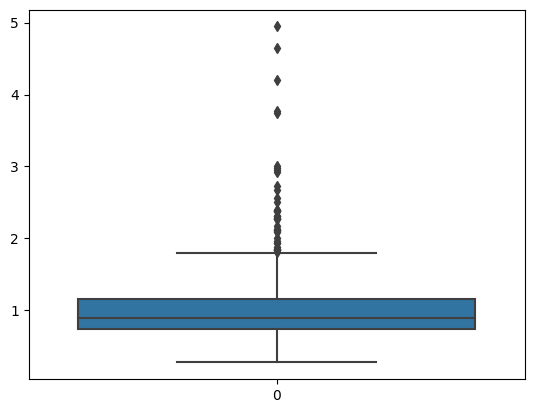

<Axes: xlabel='outlier_score_min', ylabel='Count'>

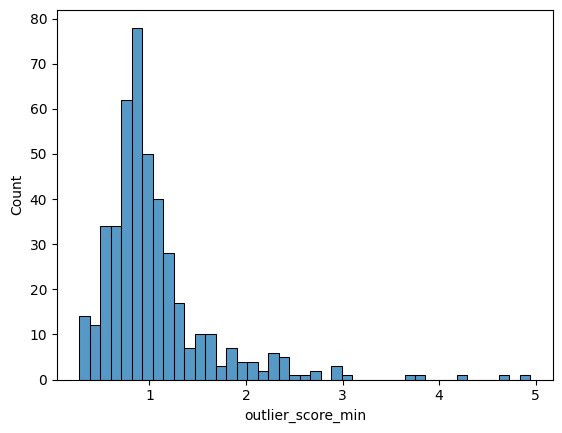

In [72]:
print(np.var(df_overview['outlier_score_min']))
display(df_overview[["outlier_score_min"]].describe())
sns.boxplot(df_overview["outlier_score_min"])
plt.show()
sns.histplot(df_overview["outlier_score_min"])
# want it to be centered/dense!

## Soft-Min Score/KDE approach

In [73]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df.to_numpy())
distances, indices = nbrs.kneighbors(df.to_numpy())
gamma = 1

def softmin(z, gamma):
    return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
df_overview.sort_values(by="outlier_score_softmin", ascending=False).head(10)

Fresh      Milk    Grocery    Frozen  Detergents_Paper  Delicassen   
338   1.386294  5.811141   8.856803  9.655154          2.772589    6.311735  \
154   6.434547  4.025352   4.927254  4.330733          2.079442    2.197225   
75    9.923241  7.037028   1.386294  8.391176          1.386294    6.883463   
95    1.386294  7.979681   8.740817  6.089045          5.411646    6.565265   
142  10.519673  8.875287   9.018453  8.005033          3.044522    1.386294   
66    2.302585  7.336286   8.911665  5.170484          8.151622    3.332205   
128   4.948760  9.087947   8.249052  4.962845          6.968850    1.386294   
218   2.944439  8.923325   9.629445  7.159292          8.475954    8.759826   
109   7.249215  9.724959  10.274603  6.513230          6.729824    1.386294   
65    4.454347  9.950371  10.732672  3.610918         10.095429    7.261225   

     outlier_score_min  outlier_score_softmin  
338           4.945913               8.707924  
154           4.201955               8.125333  
75            4.647444               8.066658  
95            3.746081               7.203478  
142           3.774788               6.732597  
66            2.306142               6.593827  
128           2.973513               6.500496  
218           2.668450               6.075874  
109           2.721484               6.057849  
65            2.567014               6.035121

In [76]:
print(distances.shape)

print(np.sum(distances == 0))
distances # aufsteigende Reihenfolge, indices enthält die zugehörigen Indices

(440, 440)
440


array([[ 0.        ,  1.08694283,  1.18434603, ..., 10.56009855,
        10.64258234, 11.02949267],
       [ 0.        ,  0.5071196 ,  0.51741715, ..., 10.09509255,
        10.60971999, 11.1630892 ],
       [ 0.        ,  1.14136835,  1.17054666, ..., 10.23094306,
        10.64797802, 11.91430113],
       ...,
       [ 0.        ,  0.98300836,  1.23805457, ..., 12.04152517,
        12.5997632 , 12.64885026],
       [ 0.        ,  0.88388059,  0.88411931, ...,  8.622275  ,
         8.98060658,  8.99269369],
       [ 0.        ,  2.3751137 ,  2.47130703, ...,  9.66735441,
         9.72841267, 10.40676458]])

0.7869366055138984


outlier_score_softmin
count             440.000000
mean                3.360544
std                 0.888104
min                 2.437838
25%                 2.801006
50%                 3.069082
75%                 3.594979
max                 8.707924

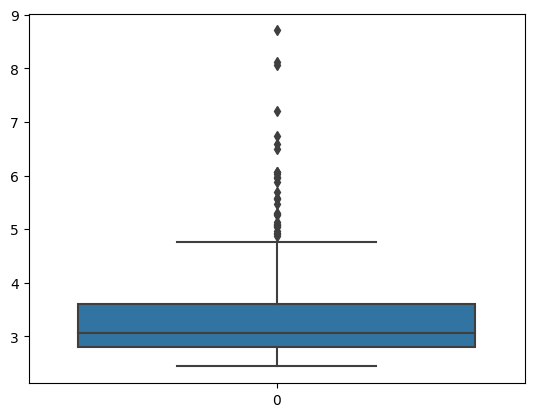

<Axes: xlabel='outlier_score_softmin', ylabel='Count'>

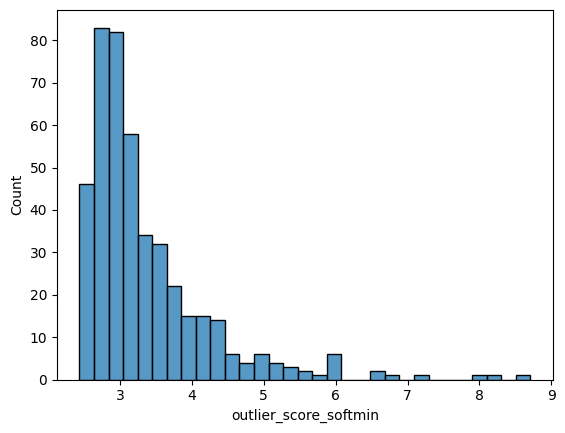

In [77]:
# TODO: Nebeneinander packem

print(np.var(df_overview['outlier_score_softmin']))
display(df_overview[["outlier_score_softmin"]].describe())
sns.boxplot(df_overview["outlier_score_softmin"])
plt.show()
sns.histplot(df_overview["outlier_score_softmin"])

## Bootstrap/Robustness estimate & choosing bandwidth

In [73]:
# import statistics

# statistics.fmean(np.exp(-gamma * distances[:, 1:][0]))


In [81]:
spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
sample = resample(df, n_samples=len(df) // 2, replace=False)
sample

Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicassen
298  8.818630   8.425297   9.206935  6.840547          8.420462    6.945051
162  9.627602   7.613325   8.245647  7.888335          5.451038    6.415097
165  9.656051   9.445729   9.896413  8.395252          8.869117    7.774856
338  1.386294   5.811141   8.856803  9.655154          2.772589    6.311735
308  8.851950   6.928538   8.009031  6.033086          5.552960    6.487684
..        ...        ...        ...       ...               ...         ...
140  9.777017   8.361942   8.896451  7.731931          6.867974    7.869784
37   9.627009   9.264544   9.431722  7.560601          8.780634    6.572283
425  9.327590   7.786967   7.860956  9.638806          4.691348    7.542744
270  8.459776   6.940222   6.883463  8.612685          5.288267    4.043051
56   8.318498  10.305380  10.198654  7.869784          9.783634    7.201171

[220 rows x 6 columns]

In [104]:
from sklearn.utils import resample

N_BOOTSTRAP = 100


g = np.linspace(0.1, 2,10)
gamma_overview = pd.DataFrame(columns=["score_discrimination_var", "model_var"])

#for gamma in g:
for gamma in g:
    spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
    for i in range(N_BOOTSTRAP):

        sample = resample(df, n_samples=len(df) // 2, replace=False)

        nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample.to_numpy())
        distances, indices = nbrs.kneighbors(sample.to_numpy())

        sm = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)

        for j, idx in enumerate(sample.index):
            spread[idx][i] = sm[j]

        #res += [np.var(list(map(np.mean, spread.values())))]
    spread_df = pd.DataFrame(spread) # 100 x 400

    gamma_overview.loc[gamma, "score_discrimination_var"] = np.var(spread_df.mean()) # discriminatory power
    gamma_overview.loc[gamma, "model_var"] = np.mean(np.var(spread_df))


#res
# sns.histplot(list(map(np.std, spread.values())))

In [108]:
spread_df.mean().describe()

count    440.000000
mean       2.830543
std        0.771055
min        2.039944
25%        2.347408
50%        2.597852
75%        3.052980
max        7.797633
dtype: float64

score_discrimination_var model_var
0.100000                 0.992725  0.005341
0.311111                 0.952415  0.004944
0.522222                 0.907737  0.004658
0.733333                 0.855236  0.004667
0.944444                 0.801663  0.005751
1.155556                 0.752557  0.006034
1.366667                 0.703939   0.00696
1.577778                 0.664271   0.00794
1.788889                 0.626188  0.009017
2.000000                 0.593175  0.010527

<Axes: ylabel='score_discrimination_var'>

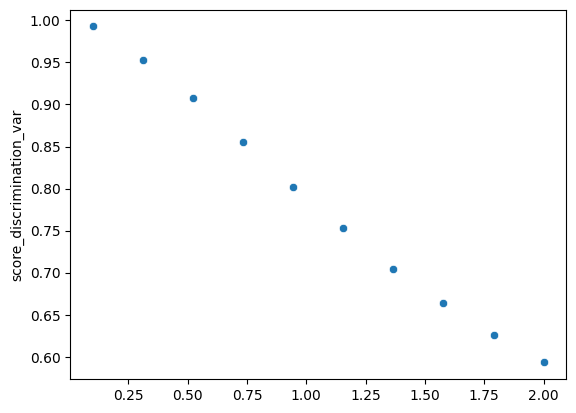

In [117]:
display(gamma_overview)

sns.scatterplot(x=gamma_overview.index, y=gamma_overview["score_discrimination_var"])


<Axes: ylabel='model_var'>

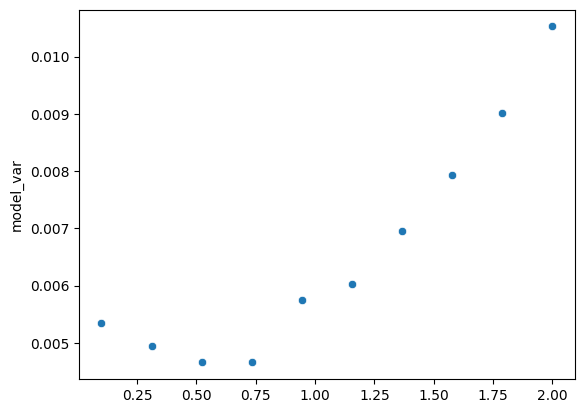

In [118]:
sns.scatterplot(x=gamma_overview.index, y=gamma_overview["model_var"])

In [93]:
spread_df = pd.DataFrame(spread) # 100 x 400
display(spread_df)
g_var_score = np.var(spread_df.mean()) # discriminatory power
g_var_model = np.mean(np.var(spread_df))

#display(spread_df.isna())
# spread_df.isna().sum() # passt

0         1         2         3         4         5         6     
0   3.099263  2.567457  3.121058       NaN  2.866174       NaN  2.814963  \
1   3.241823       NaN  3.221216  2.737695  3.036671  2.794379       NaN   
2   3.172873       NaN       NaN  2.689354       NaN       NaN       NaN   
3   3.217984       NaN  3.264212  2.718096       NaN  2.724497  2.887450   
4   3.265505       NaN       NaN  2.676450       NaN  2.737374  2.909622   
..       ...       ...       ...       ...       ...       ...       ...   
95  3.130817       NaN       NaN       NaN       NaN       NaN  2.845196   
96       NaN       NaN  3.151632  2.717762  2.911580  2.642907       NaN   
97       NaN       NaN       NaN       NaN  2.955910       NaN  2.912829   
98  3.078548  2.587797       NaN  2.736836  3.012445       NaN  2.738908   
99  3.185393       NaN       NaN       NaN       NaN  2.691544       NaN   

         7         8         9    ...       430       431       432       433   
0        NaN  2.710245  2.857824  ...  3.454618  3.044289  3.265396       NaN  \
1   2.722484       NaN       NaN  ...  3.457796       NaN       NaN       NaN   
2   2.660672  2.757662       NaN  ...       NaN       NaN       NaN       NaN   
3   2.685872  2.790275  2.892096  ...  3.513867  3.050640       NaN  2.970508   
4   2.714806       NaN       NaN  ...       NaN       NaN       NaN  2.942841   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95       NaN  2.760183       NaN  ...  3.467628       NaN       NaN  2.875872   
96       NaN  2.759947       NaN  ...       NaN  3.001728       NaN       NaN   
97       NaN       NaN       NaN  ...  3.417025  2.990979  3.289769  2.831733   
98       NaN  2.633415       NaN  ...       NaN  3.054918  3.143479  2.876465   
99       NaN       NaN       NaN  ...       NaN  3.136283  3.217423  2.941652   

         434       435       436       437       438       439  
0   2.630317       NaN       NaN       NaN       NaN       NaN  
1   2.848503       NaN  3.517276       NaN  2.752786  4.646511  
2   2.680921  3.850161  3.405133  3.603611  2.731753       NaN  
3   2.721769       NaN  3.424946  3.640058  2.741180       NaN  
4   2.752566  3.799215  3.376149  3.767148  2.639155       NaN  
..       ...       ...       ...       ...       ...       ...  
95  2.658520       NaN       NaN  3.515013  2.665118  4.772075  
96       NaN       NaN       NaN       NaN       NaN  4.661384  
97  2.755117  3.816817       NaN       NaN  2.717500  4.685583  
98  2.620316       NaN       NaN       NaN  2.755710       NaN  
99       NaN  3.964196  3.567696  3.605269  2.854957       NaN  

[100 rows x 440 columns]

0      0.003654
1      0.004629
2      0.003814
3      0.002882
4      0.005707
         ...   
435    0.003645
436    0.004443
437    0.007398
438    0.004307
439    0.003086
Length: 440, dtype: float64

In [85]:
spread_df.isna().sum()

0      0
1      0
2      0
3      0
4      1
      ..
435    0
436    0
437    0
438    1
439    0
Length: 440, dtype: int64

In [38]:
np.array([1,2,3,4]).shape

(4,)

In [37]:
spread

{0: array([], shape=(100, 0), dtype=float64),
 1: array([], shape=(100, 0), dtype=float64),
 2: array([], shape=(100, 0), dtype=float64),
 3: array([], shape=(100, 0), dtype=float64),
 4: array([], shape=(100, 0), dtype=float64),
 5: array([], shape=(100, 0), dtype=float64),
 6: array([], shape=(100, 0), dtype=float64),
 7: array([], shape=(100, 0), dtype=float64),
 8: array([], shape=(100, 0), dtype=float64),
 9: array([], shape=(100, 0), dtype=float64),
 10: array([], shape=(100, 0), dtype=float64),
 11: array([], shape=(100, 0), dtype=float64),
 12: array([], shape=(100, 0), dtype=float64),
 13: array([], shape=(100, 0), dtype=float64),
 14: array([], shape=(100, 0), dtype=float64),
 15: array([], shape=(100, 0), dtype=float64),
 16: array([], shape=(100, 0), dtype=float64),
 17: array([], shape=(100, 0), dtype=float64),
 18: array([], shape=(100, 0), dtype=float64),
 19: array([], shape=(100, 0), dtype=float64),
 20: array([], shape=(100, 0), dtype=float64),
 21: array([], shape=(1

In [29]:
sample = resample(df, n_samples=len(df) // 2, replace=False)
sample.head()
nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample.to_numpy())
distances, indices = nbrs.kneighbors(sample.to_numpy())
sm = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
sm

array([2.59729819, 2.42939831, 2.69038155, 2.25298139, 5.04400009,
       2.92474403, 2.3534859 , 2.94522805, 3.05795063, 2.71010028,
       2.22322181, 2.18365503, 2.33618541, 2.90363533, 3.11871778,
       2.27091535, 2.4470575 , 2.20551857, 4.1154353 , 3.04110127,
       3.25302244, 2.49251105, 2.09964301, 2.18577146, 2.31616037,
       2.84333448, 3.09297251, 3.07946028, 2.2378419 , 2.31690273,
       2.4913253 , 2.44510122, 3.48880378, 2.55795248, 5.25992178,
       3.91518595, 3.4636296 , 2.16650509, 2.46642517, 2.75760517,
       2.47170029, 2.54144299, 3.55020527, 3.30744387, 2.98464229,
       2.09756509, 2.21061424, 2.76156735, 2.5529268 , 2.56348693,
       2.7821182 , 5.85452672, 2.91146179, 5.43943329, 7.35312766,
       2.39127846, 2.86066949, 2.27005111, 2.92208938, 3.00973351,
       2.40799646, 2.32260387, 3.79371396, 2.8623779 , 3.01308127,
       2.50581106, 2.86777626, 2.72791662, 2.40157464, 2.59819879,
       2.38624077, 2.17533468, 2.43641246, 2.29129411, 2.59734

In [21]:
list(map(np.std, spread.values()))

[0.35996636092112694,
 0.43449561957135,
 0.38898028017133573,
 0.3879492741615212,
 0.41052010241982295,
 0.32152419505722424,
 0.3367272970402165,
 0.4258690154477348,
 0.2964141696597853,
 0.5472512573898467,
 0.4358951295822421,
 0.31225281695008106,
 0.45449717143779017,
 0.4257946759501691,
 0.4785784169033224,
 0.32607074693949034,
 0.5711957669002066,
 0.2632223738210566,
 0.44968913252648235,
 0.30125902024058854,
 0.37989709231070745,
 0.410259742534888,
 0.37508026819214874,
 0.5056264496652637,
 0.46218882720138854,
 0.43886891350247004,
 0.44077608911843463,
 0.4406000119708566,
 0.5846491126541504,
 0.3082853577930488,
 0.39354975181860047,
 0.2556205830250065,
 0.3446226370937376,
 0.3750303957503954,
 0.30265599395023246,
 0.4313839428014841,
 0.36141568353227865,
 0.4783764536379107,
 0.6306648596235809,
 0.4473799119021496,
 0.41774422889609897,
 0.36228353680458075,
 0.5535523751212159,
 0.6250912328352252,
 0.3764328556694939,
 0.56894010487409,
 0.5519102764779188,

In [22]:
spread

{0: array([4.00893128, 3.85613215, 3.95281508, 3.90486123, 3.81872119,
        3.9147329 , 3.79659195, 3.79412068, 3.87999075, 3.96105139,
        3.94686203, 3.89658491, 3.86803034, 3.75158051, 4.00420327,
        3.84777491, 3.84810835, 4.05058319, 3.84816802, 3.95272978,
        3.92091982, 4.0639292 , 3.83871884, 3.94052021, 3.76881911,
        4.01650813, 3.93998806, 3.88285767, 3.91963549, 3.69817503,
        3.8893788 , 3.96290434, 3.99111722, 3.89724692, 3.86185157,
        3.98760642, 3.83421061, 3.79764907, 3.92599936, 3.87554997,
        3.95821762, 3.80798139, 3.90958406, 3.90820693, 3.97087427,
        3.90408087, 3.86854363, 3.79700944, 3.97313256, 3.91588137,
        3.93172898, 3.88561852, 3.7727513 , 3.71270643, 3.7643553 ,
        3.75749092, 3.68289271, 3.74945079, 3.81338453, 3.67917706,
        3.76420015, 3.74145182, 3.6648468 , 3.59229959, 3.81400795,
        3.71799604, 3.75346137, 3.67236731, 3.76471549, 3.84149658,
        3.68296783, 3.76847367, 3.66811899, 3

<Axes: >

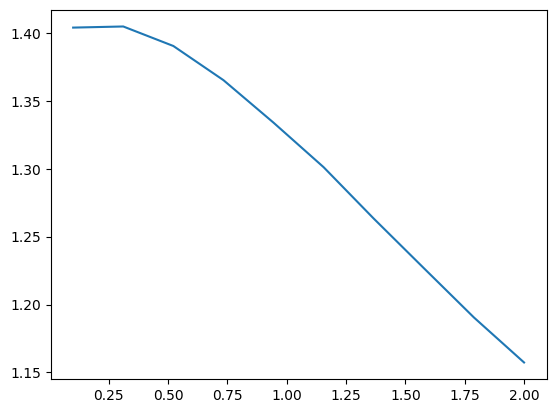

In [23]:
sns.lineplot(x=g, y=res)

need 2 measures to compare: robustness vs. value of score (how much it discriminates between outliers and "regular" points); check picture from Montavon. Visual examination/optimal point. Compare to hard min


Cluster = Partition der Daten um sie zusammenzufassen, nicht unbedingt obvious

# TEST IDEA

Certainly! Here's a step-by-step guide on how to perform the bootstrapping analysis to assess the robustness of anomaly detection methods using soft min-pooling:

1. Start with a dataset that contains both normal and anomalous instances.

2. Randomly split the dataset into two equal-sized subsets. These subsets will serve as the two variants of the original dataset that we will use to calculate the spread of anomaly scores.

3. For each subset, compute the anomaly scores for each instance using soft min-pooling with a specific value of the parameter γ. Repeat this process for different values of γ.

4. For each instance, calculate the difference between its anomaly score in the two subsets. This will give you a measure of how much the anomaly score varies when different subsets of the data are used.

5. Compute the standard deviation of the differences across all instances. This will give you an estimate of the spread of anomaly scores for a given value of γ.

6. Repeat steps 2-5 multiple times, with different random splits of the dataset. This will give you a distribution of spread estimates for each value of γ.

7. Analyze the distribution of spread estimates to determine the optimal value of γ that achieves the desired level of robustness. A small value of γ may lead to more robust estimates, but setting γ too small may introduce bias. You will need to find an appropriate tradeoff between robustness and bias.

Overall, bootstrapping can help assess the robustness of anomaly detection methods using soft min-pooling and determine the optimal value of γ that achieves the desired level of robustness.


In [78]:
def softmin2(z, gamma):
    if z[0] == 0:
        z = z[1:]
    else:
        z = z[0:-1]

    return -1 / gamma * np.log(1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z))

<Axes: >

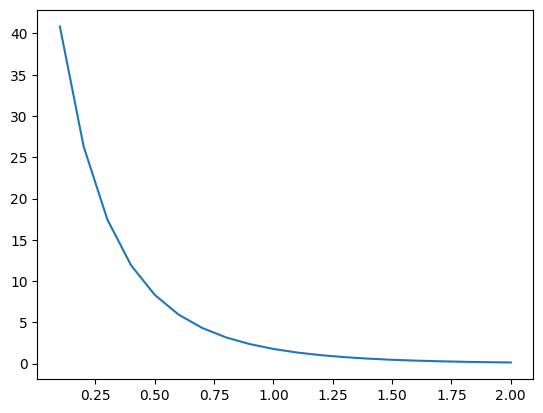

In [79]:
res = np.zeros((10, 20))

for i in range(10):

    # Creating a dataframe with 50% values of original dataframe
    part_50 = df.sample(frac = 0.5)
    
    # Creating dataframe with rest of the 50% values
    rest_part_50 = df.drop(part_50.index)

    nbrs1 = NearestNeighbors(n_neighbors=len(part_50), algorithm="ball_tree").fit(part_50.to_numpy())
    distances1, indices1 = nbrs1.kneighbors(df.to_numpy())

    nbrs2 = NearestNeighbors(n_neighbors=len(rest_part_50), algorithm="ball_tree").fit(rest_part_50.to_numpy())
    distances2, indices2 = nbrs2.kneighbors(df.to_numpy())

    

    for j, gamma in enumerate(np.linspace(0.1, 2, 20)):
        sm1 = np.apply_along_axis(softmin2, 1, distances1, gamma)
        sm2 = np.apply_along_axis(softmin2, 1, distances2, gamma)
        res[i, j] = np.std(sm2 - sm1)


# sns.histplot(sm2 - sm1)

sns.lineplot(x = np.linspace(0.1, 2, 20), y=np.std(res, axis=0))

<Axes: ylabel='Count'>

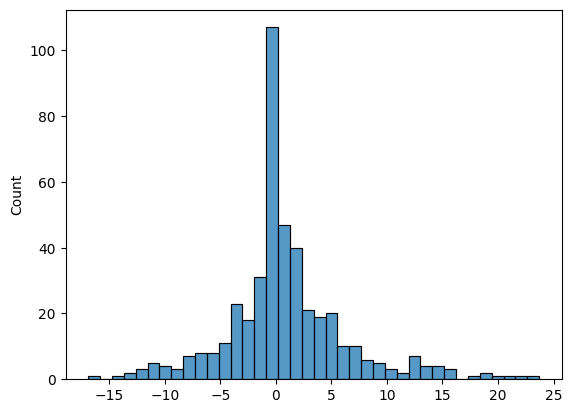

In [80]:
gamma = 1
sm1 = np.apply_along_axis(softmin2, 1, distances1**2, gamma)
sm2 = np.apply_along_axis(softmin2, 1, distances2**2, gamma)
sns.histplot(sm2 - sm1)

In [81]:
gamma = 1
-1/gamma * np.log(1/220)

5.393627546352361

In [82]:
np.log(np.exp(1))

0.9999999999999999